# Notes nn - Predictors of recorded DS live births

- Drop calibration (makes no difference)


## Preparation


In [25]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0009-predictors-9/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-30T19:39:24.568645
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 60 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0009-predictors-9/20251230-193924
--------------------



### Options


In [26]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.7
VALIDATION_SPLIT = 0.3
# CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 50
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [27]:
df = data_utils.load_predictors_data(
    from_year=START_YEAR, to_year=END_YEAR, include_unknown=True
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [28]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    # vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    # vars.DOB_MM,
    # vars.DOB_WK,
    # "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"].replace({pd.NA: 0, np.nan: 0}).astype(np.int32)

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=(1-TRAINING_SPLIT), stratify=y, random_state=RANDOM_SEED
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [30]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)

Training set: 23499993 negatives, 12466 positives, probability positive 0.00053047
Validation set: 10071426 negatives, 5343 positives, probability positive 0.00053051


In [31]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.0078081330257775035,
    "num_leaves": 161,
    "min_data_in_leaf": 645,
    "min_gain_to_split": 0.8103586768870157,
    "feature_fraction": 0.8196457887746891,
    "bagging_fraction": 0.751968270917625,
    "bagging_freq": 1,
    "lambda_l1": 0.00010820748727746452,
    "lambda_l2": 1.2361559622164608e-08,
}

## Hyperparameter tuning


In [32]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.75, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-30 19:40:19,839] A new study created in memory with name: no-name-0419159a-e12c-45e4-bd3f-a96af6e9d037


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.00301266	valid_0's binary_logloss: 0.0384793
[20]	valid_0's average_precision: 0.00284565	valid_0's binary_logloss: 0.0462016
[30]	valid_0's average_precision: 0.00347117	valid_0's binary_logloss: 0.0202525
[40]	valid_0's average_precision: 0.000971474	valid_0's binary_logloss: 1.00548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

[I 2025-12-30 19:41:11,599] Trial 0 finished with value: 0.012527066994280115 and parameters: {'learning_rate': 0.5896940421942092, 'num_leaves': 37, 'min_data_in_leaf': 619, 'min_gain_to_split': 0.4802721664641433, 'feature_fraction': 0.7032817126874467, 'bagging_fraction': 0.6352816675919115, 'bagging_freq': 8, 'lambda_l1': 0.002582212781912497, 'lambda_l2': 1.885528888083222e-06}. Best is trial 0 with value: 0.012527066994280115.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0125271	valid_0's binary_logloss: 0.0426026
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0232448	valid_0's binary_logloss: 0.00401645
[20]	valid_0's average_precision: 0.0243484	valid_0's binary_logloss: 0.00388737
[30]	valid_0's average_precision: 0.0249974	valid_0's binary_logloss: 0.00380996
[40]	valid_0's average_precision: 0.025357	valid_0's binary_logloss: 0.00375813
[50]	valid_0's average_precision: 0.0257631	valid_0's binary_logloss: 0.00372206
[60]	valid_0's average_precision: 0.0260024	valid_0's binary_logloss: 0.00369685
[70

[I 2025-12-30 19:49:46,842] Trial 1 finished with value: 0.02853900203411587 and parameters: {'learning_rate': 0.021745792778520828, 'num_leaves': 73, 'min_data_in_leaf': 3019, 'min_gain_to_split': 0.03582336251267382, 'feature_fraction': 0.8758353685178296, 'bagging_fraction': 0.9239302093273247, 'bagging_freq': 8, 'lambda_l1': 0.005834565710478459, 'lambda_l2': 0.00026803364732677117}. Best is trial 1 with value: 0.02853900203411587.


Early stopping, best iteration is:
[392]	valid_0's average_precision: 0.028539	valid_0's binary_logloss: 0.00360109
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 19:49:49,578] Trial 2 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 19:49:53,035] Trial 3 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0262078	valid_0's binary_logloss: 0.00418153
[20]	valid_0's average_precision: 0.0271484	valid_0's binary_logloss: 0.00405768
[30]	valid_0's average_precision: 0.0279254	valid_0's binary_logloss: 0.0039745
[40]	valid_0's average_precision: 0.0284078	valid_0's binary_logloss: 0.00391132
[50]	valid_0's average_precision: 0.0289641	valid_0's binary_logloss: 0.00386457
[60]	valid_0's average_precision: 0.0292282	valid_0's binary_logloss: 0.0038278
[70]	valid_0's average_precision: 0.0294655	valid_0's binary_logloss: 0.0037976
[80]	valid_0's average_precision: 0.02

[I 2025-12-30 19:53:31,778] Trial 4 finished with value: 0.030280843315046106 and parameters: {'learning_rate': 0.009018574494459457, 'num_leaves': 177, 'min_data_in_leaf': 2082, 'min_gain_to_split': 0.15360226633453977, 'feature_fraction': 0.9164212405085258, 'bagging_fraction': 0.7833918412568526, 'bagging_freq': 9, 'lambda_l1': 4.5358881195096527e-07, 'lambda_l2': 0.007012512012175677}. Best is trial 4 with value: 0.030280843315046106.


Early stopping, best iteration is:
[148]	valid_0's average_precision: 0.0302808	valid_0's binary_logloss: 0.00367316
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 19:53:35,704] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0256034	valid_0's binary_logloss: 0.00403012
[20]	valid_0's average_precision: 0.0267592	valid_0's binary_logloss: 0.00389416
[30]	valid_0's average_precision: 0.0274939	valid_0's binary_logloss: 0.00381424
[40]	valid_0's average_precision: 0.027822	valid_0's binary_logloss: 0.00375827
[50]	valid_0's average_precision: 0.0281792	valid_0's binary_logloss: 0.00372163
[60]	valid_0's average_precision: 0.0284048	valid_0's binary_logloss: 0.00369488
[70]	valid_0's average_precision: 0.0286661	valid_0's binary_logloss: 0.00367495
[80]	valid_0's average_precision: 0.

[I 2025-12-30 19:59:52,210] Trial 6 finished with value: 0.02947442096183316 and parameters: {'learning_rate': 0.020561961603174223, 'num_leaves': 207, 'min_data_in_leaf': 3609, 'min_gain_to_split': 0.743735303001152, 'feature_fraction': 0.7735222671929762, 'bagging_fraction': 0.8969586168698785, 'bagging_freq': 3, 'lambda_l1': 5.807034975564744e-07, 'lambda_l2': 4.2967234871592924e-07}. Best is trial 4 with value: 0.030280843315046106.


Early stopping, best iteration is:
[216]	valid_0's average_precision: 0.0294744	valid_0's binary_logloss: 0.00360912
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0246155	valid_0's binary_logloss: 0.00411881
[20]	valid_0's average_precision: 0.025788	valid_0's binary_logloss: 0.0039828
[30]	valid_0's average_precision: 0.0265416	valid_0's binary_logloss: 0.00389545
[40]	valid_0's average_precision: 0.0270228	valid_0's binary_logloss: 0.00383417
[50]	valid_0's average_precision: 0.0275835	valid_0's binary_logloss: 0.00378999
[60]	valid_0's average_precision: 0.0276955	valid_0's binary_logloss: 0.00375774
[

[I 2025-12-30 20:02:58,653] Trial 7 finished with value: 0.028485161799437702 and parameters: {'learning_rate': 0.013132233557351256, 'num_leaves': 343, 'min_data_in_leaf': 3155, 'min_gain_to_split': 0.4790936602720103, 'feature_fraction': 0.9294908219619215, 'bagging_fraction': 0.6161241991336115, 'bagging_freq': 6, 'lambda_l1': 7.061913826658877e-07, 'lambda_l2': 0.0002215275459629905}. Best is trial 4 with value: 0.030280843315046106.


Early stopping, best iteration is:
[105]	valid_0's average_precision: 0.0284852	valid_0's binary_logloss: 0.00367374
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:03:01,439] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:03:05,805] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.0182229	valid_0's binary_logloss: 0.00382178
[20]	valid_0's average_precision: 0.0223548	valid_0's binary_logloss: 0.00371391
[30]	valid_0's average_precision: 0.0237001	valid_0's binary_logloss: 0.00366781
[40]	valid_0's average_precision: 0.025594	valid_0's binary_logloss: 0.0036427
[50]	valid_0's average_precision: 0.0263065	valid_0's binary_logloss: 0.00363054
[60]	valid_0's average_precision: 0.0267352	valid_0's binary_logloss: 0.00362301
[70]	valid_0's average_precision: 0.0270837

[I 2025-12-30 20:06:24,826] Trial 10 finished with value: 0.0272673545438386 and parameters: {'learning_rate': 0.06032033703727803, 'num_leaves': 187, 'min_data_in_leaf': 8083, 'min_gain_to_split': 0.23345545021707298, 'feature_fraction': 0.977450866440595, 'bagging_fraction': 0.8353209316347484, 'bagging_freq': 10, 'lambda_l1': 4.455488595663342, 'lambda_l2': 0.027495996915911963}. Best is trial 4 with value: 0.030280843315046106.


Early stopping, best iteration is:
[84]	valid_0's average_precision: 0.0272674	valid_0's binary_logloss: 0.00361499
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:06:28,038] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0263652	valid_0's binary_logloss: 0.00424216
[20]	valid_0's average_precision: 0.0270932	valid_0's binary_logloss: 0.00413011
[30]	valid_0's average_precision: 0.0276343	valid_0's binary_logloss: 0.00405191
[40]	valid_0's average_precision: 0.0280287	valid_0's binary_logloss: 0.00399105
[50]	valid_0's average_precision: 0.0284745	valid_0's binary_logloss: 0.00394424
[60]	valid_0's average_precision: 0.0286041	valid_0's binary_logloss: 0.00390714
[70]	valid_0's average_precision: 0.0288376	valid_0's binary_logloss: 0.00387539
[80]	valid_0's average_precision: 0

[I 2025-12-30 20:15:21,307] Trial 12 finished with value: 0.030600555757335376 and parameters: {'learning_rate': 0.006245029018567011, 'num_leaves': 199, 'min_data_in_leaf': 1542, 'min_gain_to_split': 0.6465488786580977, 'feature_fraction': 0.893369904582961, 'bagging_fraction': 0.8176415632088767, 'bagging_freq': 4, 'lambda_l1': 1.4187046643490807e-06, 'lambda_l2': 2.0505527895771157e-08}. Best is trial 12 with value: 0.030600555757335376.


Early stopping, best iteration is:
[369]	valid_0's average_precision: 0.0306006	valid_0's binary_logloss: 0.00362479
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:15:25,598] Trial 13 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:15:28,933] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0265709	valid_0's binary_logloss: 0.00426702
[20]	valid_0's average_precision: 0.0275792	valid_0's binary_logloss: 0.00415892
[30]	valid_0's average_precision: 0.0281075	valid_0's binary_logloss: 0.00408305
[40]	valid_0's average_precision: 0.0284528	valid_0's binary_logloss: 0.0040251
[50]	valid_0's average_precision: 0.0285443	valid_0's binary_logloss: 0.00397908
[60]	valid_0's average_precision: 0.0287493	valid_0's binary_logloss: 0.00394117
[70]	valid_0's average_precision: 0.028807	valid_0's binary_logloss: 0.00390912
[80]	valid_0's average_precision: 0.0

[I 2025-12-30 20:22:45,149] Trial 15 finished with value: 0.030213827309363207 and parameters: {'learning_rate': 0.005212846491212794, 'num_leaves': 279, 'min_data_in_leaf': 1321, 'min_gain_to_split': 0.9681237720567124, 'feature_fraction': 0.9299155480943295, 'bagging_fraction': 0.6904758374006309, 'bagging_freq': 5, 'lambda_l1': 7.489714025368585e-06, 'lambda_l2': 0.002967340047463816}. Best is trial 12 with value: 0.030600555757335376.


Early stopping, best iteration is:
[322]	valid_0's average_precision: 0.0302138	valid_0's binary_logloss: 0.00364934
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:22:49,365] Trial 16 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:22:57,915] Trial 17 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:23:02,088] Trial 18 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:23:12,176] Trial 19 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:23:24,766] Trial 20 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:23:29,012] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.026898	valid_0's binary_logloss: 0.00417991
[20]	valid_0's average_precision: 0.0279053	valid_0's binary_logloss: 0.00405736
[30]	valid_0's average_precision: 0.028429	valid_0's binary_logloss: 0.0039749
[40]	valid_0's average_precision: 0.0288186	valid_0's binary_logloss: 0.00391267
[50]	valid_0's average_precision: 0.0291678	valid_0's binary_logloss: 0.00386673
[60]	valid_0's average_precision: 0.0293901	valid_0's binary_logloss: 0.00383036
[70]	valid_0's average_precision: 0.0295918	valid_0's binary_logloss: 0.00380023
[80]	valid_0's average_precision: 0.02

[I 2025-12-30 20:26:49,658] Trial 22 finished with value: 0.030174471460773917 and parameters: {'learning_rate': 0.008890631740591147, 'num_leaves': 273, 'min_data_in_leaf': 1198, 'min_gain_to_split': 0.9941632866457928, 'feature_fraction': 0.9114882473564401, 'bagging_fraction': 0.7156672659781201, 'bagging_freq': 6, 'lambda_l1': 1.5062249887066689e-06, 'lambda_l2': 0.000762257126309505}. Best is trial 12 with value: 0.030600555757335376.


[180]	valid_0's average_precision: 0.0300864	valid_0's binary_logloss: 0.0036566
Early stopping, best iteration is:
[130]	valid_0's average_precision: 0.0301745	valid_0's binary_logloss: 0.00369444
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:26:53,767] Trial 23 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0259764	valid_0's binary_logloss: 0.00409831
[20]	valid_0's average_precision: 0.0270233	valid_0's binary_logloss: 0.00397204
[30]	valid_0's average_precision: 0.0276759	valid_0's binary_logloss: 0.00389118
[40]	valid_0's average_precision: 0.028013	valid_0's binary_logloss: 0.0038324
[50]	valid_0's average_precision: 0.0284321	valid_0's binary_logloss: 0.00379074
[60]	valid_0's average_precision: 0.028688	valid_0's binary_logloss: 0.00375855
[70]	valid_0's average_precision: 0.0288618	valid_0's binary_logloss: 0.00373295
[80]	valid_0's average_precision: 0.02

[I 2025-12-30 20:31:08,795] Trial 24 finished with value: 0.029089752240048432 and parameters: {'learning_rate': 0.01317330152469093, 'num_leaves': 328, 'min_data_in_leaf': 862, 'min_gain_to_split': 0.7247082732256084, 'feature_fraction': 0.8819175816989122, 'bagging_fraction': 0.8022342881727591, 'bagging_freq': 2, 'lambda_l1': 0.00026526979218633487, 'lambda_l2': 9.320403556395469e-05}. Best is trial 12 with value: 0.030600555757335376.


Early stopping, best iteration is:
[142]	valid_0's average_precision: 0.0290898	valid_0's binary_logloss: 0.0036475
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0264206	valid_0's binary_logloss: 0.00426794
[20]	valid_0's average_precision: 0.0269263	valid_0's binary_logloss: 0.00415516


[I 2025-12-30 20:31:36,732] Trial 25 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:31:41,110] Trial 26 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:31:44,100] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:31:54,469] Trial 28 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:31:58,093] Trial 29 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:32:01,329] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:32:05,441] Trial 31 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:32:08,353] Trial 32 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:32:11,728] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:32:14,506] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0273999	valid_0's binary_logloss: 0.00406736
[20]	valid_0's average_precision: 0.0278818	valid_0's binary_logloss: 0.00394068
[30]	valid_0's average_precision: 0.0285919	valid_0's binary_logloss: 0.00386104
[40]	valid_0's average_precision: 0.0289293	valid_0's binary_logloss: 0.00380363
[50]	valid_0's average_precision: 0.0291683	valid_0's binary_logloss: 0.00376312
[60]	valid_0's average_precision: 0.0294603	valid_0's binary_logloss: 0.00373296
[70]	valid_0's average_precision: 0.0297046	valid_0's binary_logloss: 0.00370919
[80]	valid_0's average_precision: 0

[I 2025-12-30 20:34:52,972] Trial 35 finished with value: 0.02984073214418415 and parameters: {'learning_rate': 0.015402618105584706, 'num_leaves': 230, 'min_data_in_leaf': 994, 'min_gain_to_split': 0.7544722971187418, 'feature_fraction': 0.8982743750169663, 'bagging_fraction': 0.7333262407266845, 'bagging_freq': 7, 'lambda_l1': 5.6726298110310226e-05, 'lambda_l2': 0.006265223671089495}. Best is trial 12 with value: 0.030600555757335376.


Early stopping, best iteration is:
[87]	valid_0's average_precision: 0.0298407	valid_0's binary_logloss: 0.00368001
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0271094	valid_0's binary_logloss: 0.00420818
[20]	valid_0's average_precision: 0.0275426	valid_0's binary_logloss: 0.00409229


[I 2025-12-30 20:35:18,979] Trial 36 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:35:21,934] Trial 37 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:35:26,446] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:35:28,962] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.024103	valid_0's binary_logloss: 0.00422722
[20]	valid_0's average_precision: 0.0256192	valid_0's binary_logloss: 0.0041067


[I 2025-12-30 20:36:07,192] Trial 40 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0271907	valid_0's binary_logloss: 0.00406941
[20]	valid_0's average_precision: 0.0277393	valid_0's binary_logloss: 0.00394292
[30]	valid_0's average_precision: 0.0285164	valid_0's binary_logloss: 0.00386248
[40]	valid_0's average_precision: 0.0287195	valid_0's binary_logloss: 0.00380444
[50]	valid_0's average_precision: 0.0290041	valid_0's binary_logloss: 0.00376401
[60]	valid_0's average_precision: 0.0293286	valid_0's binary_logloss: 0.00373394
[70]	valid_0's average_precision: 0.0294644	valid_0's binary_logloss: 0.00370994
[80]	valid_0's average_precision: 0

[I 2025-12-30 20:41:06,623] Trial 41 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:41:16,348] Trial 42 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:41:19,816] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0264763	valid_0's binary_logloss: 0.00423161
[20]	valid_0's average_precision: 0.0270759	valid_0's binary_logloss: 0.0041204


[I 2025-12-30 20:41:44,744] Trial 44 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:41:47,642] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:41:50,577] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-30 20:41:53,819] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0265447	valid_0's binary_logloss: 0.00417066
[20]	valid_0's average_precision: 0.0276394	valid_0's binary_logloss: 0.00404618
[30]	valid_0's average_precision: 0.028269	valid_0's binary_logloss: 0.00396203
[40]	valid_0's average_precision: 0.0286863	valid_0's binary_logloss: 0.00390033
[50]	valid_0's average_precision: 0.029176	valid_0's binary_logloss: 0.00385424
[60]	valid_0's average_precision: 0.02944	valid_0's binary_logloss: 0.00381757
[70]	valid_0's average_precision: 0.0295157	valid_0's binary_logloss: 0.00378722
[80]	valid_0's average_precision: 0.029

[I 2025-12-30 20:46:03,993] Trial 48 finished with value: 0.030283271401799202 and parameters: {'learning_rate': 0.009322818343800993, 'num_leaves': 208, 'min_data_in_leaf': 1423, 'min_gain_to_split': 0.0638027648312337, 'feature_fraction': 0.9409318385681466, 'bagging_fraction': 0.7557792579063553, 'bagging_freq': 7, 'lambda_l1': 1.0583561815384703e-05, 'lambda_l2': 0.012021340063656759}. Best is trial 12 with value: 0.030600555757335376.


Early stopping, best iteration is:
[174]	valid_0's average_precision: 0.0302833	valid_0's binary_logloss: 0.00365096
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0252987	valid_0's binary_logloss: 0.00418563
[20]	valid_0's average_precision: 0.0263584	valid_0's binary_logloss: 0.00405915


[I 2025-12-30 20:46:34,181] Trial 49 pruned. Trial was pruned at iteration 27.


{'learning_rate': 0.006245029018567011, 'num_leaves': 199, 'min_data_in_leaf': 1542, 'min_gain_to_split': 0.6465488786580977, 'feature_fraction': 0.893369904582961, 'bagging_fraction': 0.8176415632088767, 'bagging_freq': 4, 'lambda_l1': 1.4187046643490807e-06, 'lambda_l2': 2.0505527895771157e-08} 0.030600555757335376
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.006245029018567011
  "num_leaves": 199
  "min_data_in_leaf": 1542
  "min_gain_to_split": 0.6465488786580977
  "feature_fraction": 0.893369904582961
  "bagging_fraction": 0.8176415632088767
  "bagging_freq": 4
  "lambda_l1": 1.4187046643490807e-06
  "lambda_l2": 2.0505527895771157e-08
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [33]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0333637	train's binary_logloss: 0.00421306	valid's average_precision: 0.0263652	valid's binary_logloss: 0.00424216
[20]	train's average_precision: 0.0358392	train's binary_logloss: 0.00408439	valid's average_precision: 0.0270932	valid's binary_logloss: 0.00413011
[30]	train's average_precision: 0.0382382	train's binary_logloss: 0.00399388	valid's average_precision: 0.0276343	valid's binary_logloss: 0.00405191
[40]	train's average_precision: 0.0399563	train's binary_logloss: 0.00392275	valid's average_precision: 0.0280287	valid's binary_logloss: 0.00399105
[50]	t

In [34]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [35]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.888782
1,Validation AP,0.030601
2,Validation log loss,0.003625
3,Precision at 10000,0.073300
4,Recall at 10000,0.137189
5,Precision (threshold=0.01),0.029150
6,Recall (threshold=0.01),0.254164


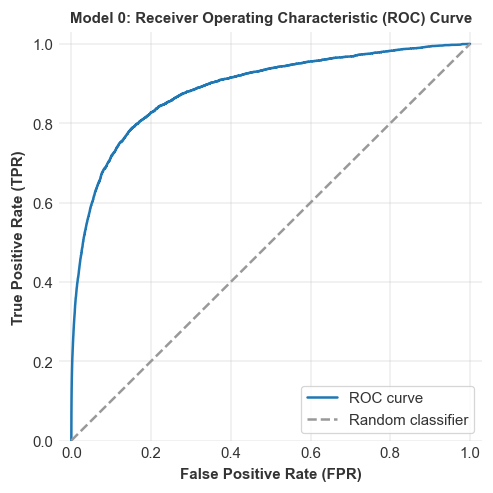

In [36]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

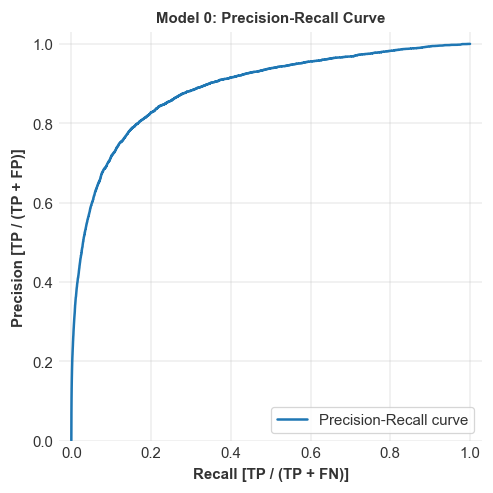

In [37]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [38]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
21,ab_nicu,1.102602e+06
46,mage_c,6.604997e+05
35,ca_disor,3.124048e+05
43,dbwt,3.079187e+05
45,bmi,1.731388e+05
27,ca_cchd,1.723844e+05
44,wtgain,1.579353e+05
3,gestrec10,1.297338e+05
47,fagecomb,1.188640e+05
19,ab_aven1,9.053091e+04


### Evaluation subset for permutation importances and SHAP analysis


In [39]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [40]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [41]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
27,ca_cchd,1.130033e-02,0.000339
35,ca_disor,1.106768e-02,0.000462
46,mage_c,9.829083e-03,0.000242
21,ab_nicu,3.589408e-03,0.000607
43,dbwt,3.000110e-03,0.000429
3,gestrec10,1.919466e-03,0.000331
16,dmeth_rec,1.434051e-03,0.000308
0,bfacil3,7.969142e-04,0.000199
20,ab_aven6,6.614661e-04,0.000159
44,wtgain,4.343321e-04,0.000240


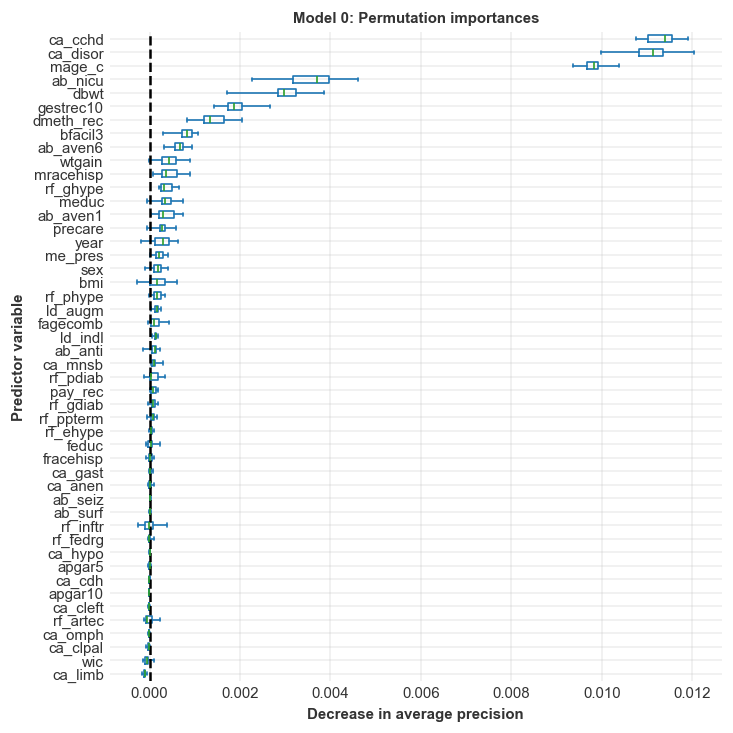

In [42]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

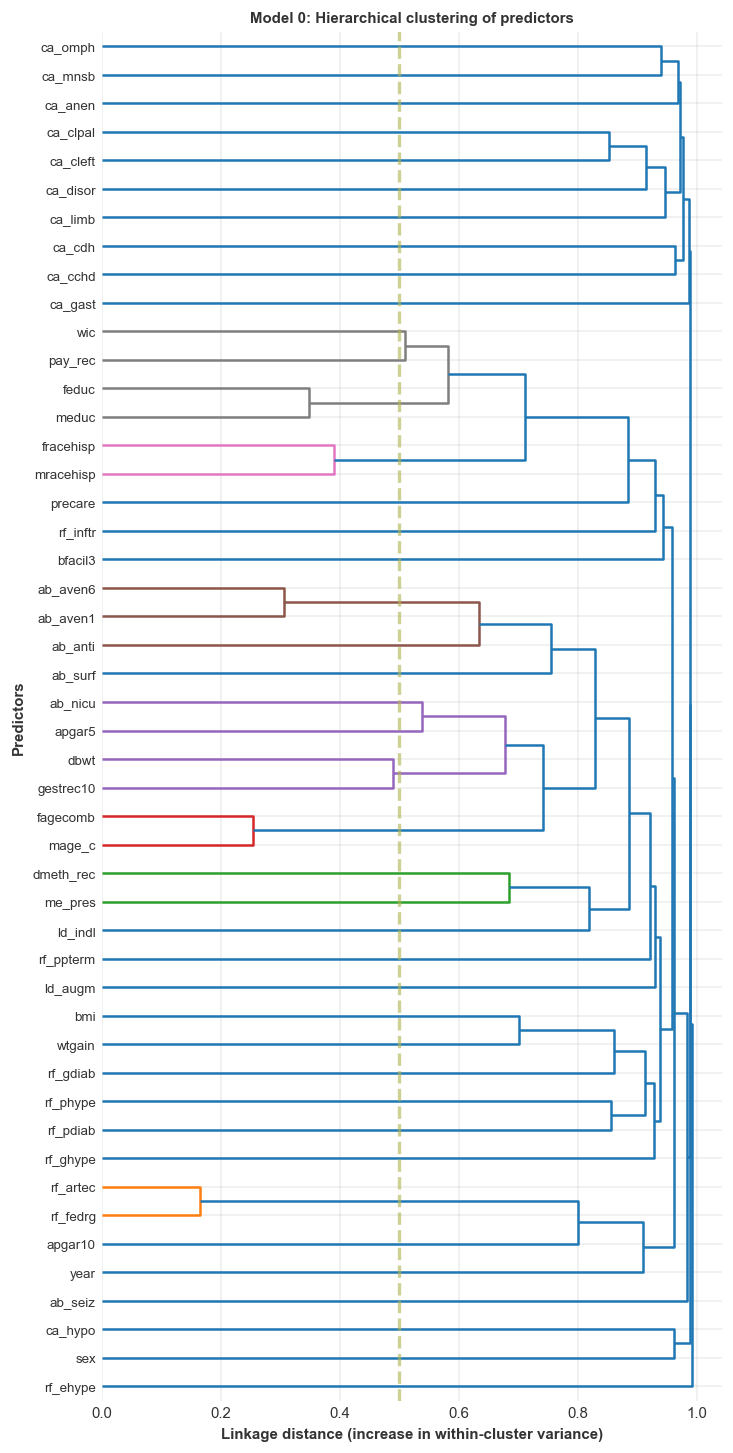

In [43]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

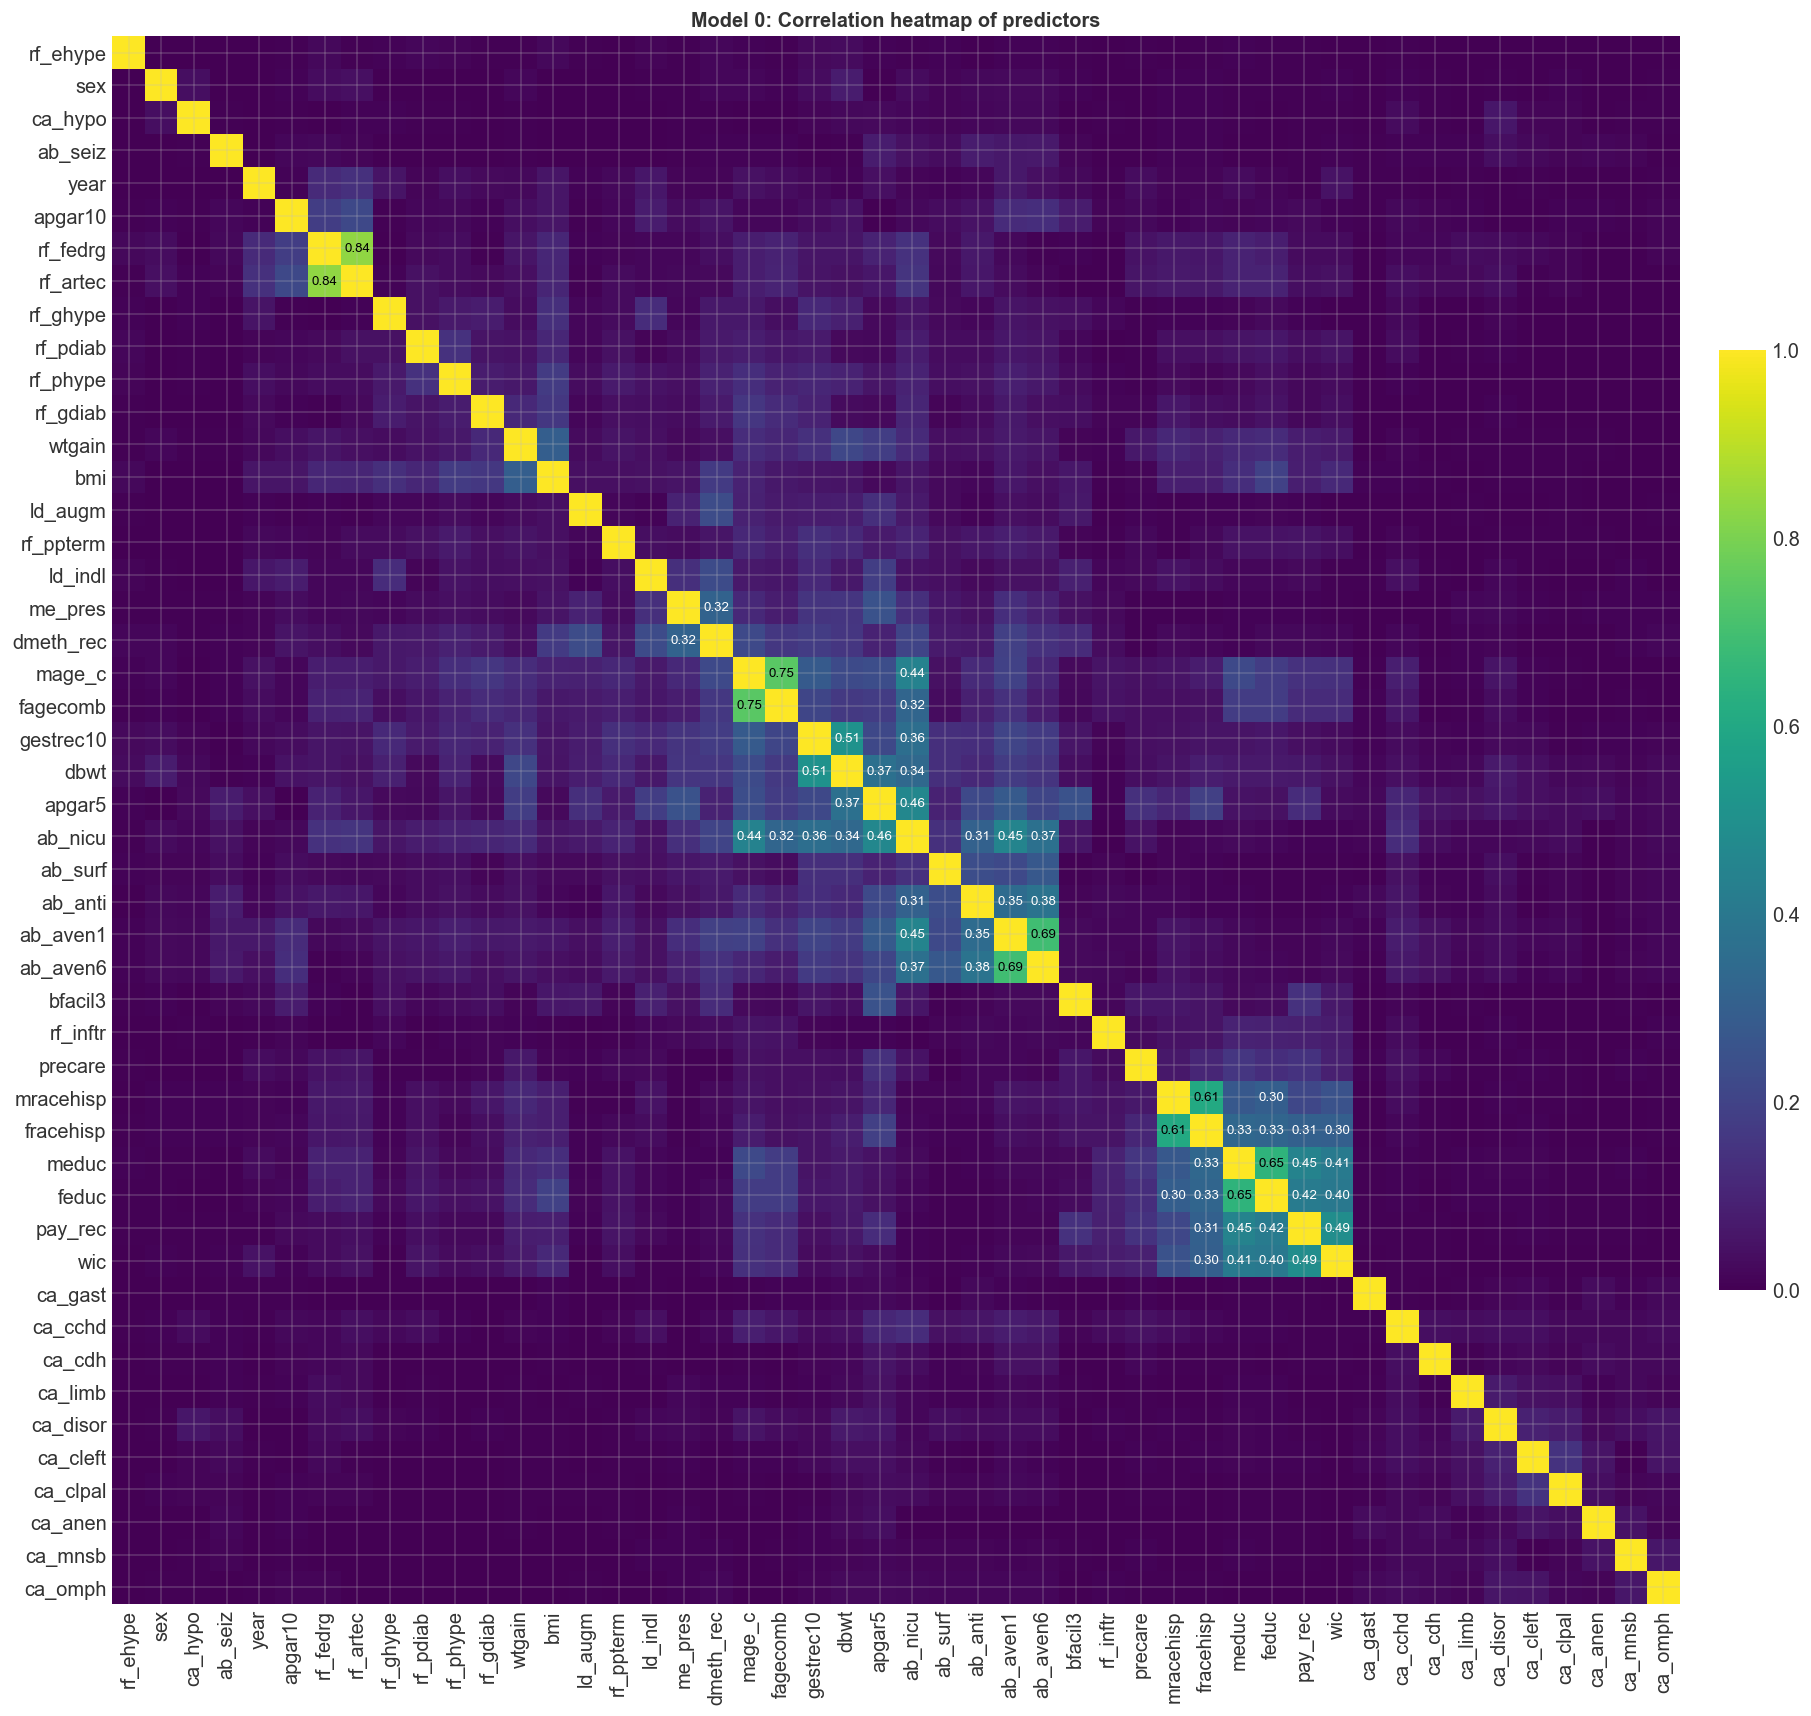

In [44]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [45]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
21,ab_nicu,0.877208
46,mage_c,0.673075
43,dbwt,0.265995
3,gestrec10,0.247601
19,ab_aven1,0.172415
27,ca_cchd,0.090393
35,ca_disor,0.089486
37,mracehisp,0.088756
44,wtgain,0.074980
20,ab_aven6,0.065801


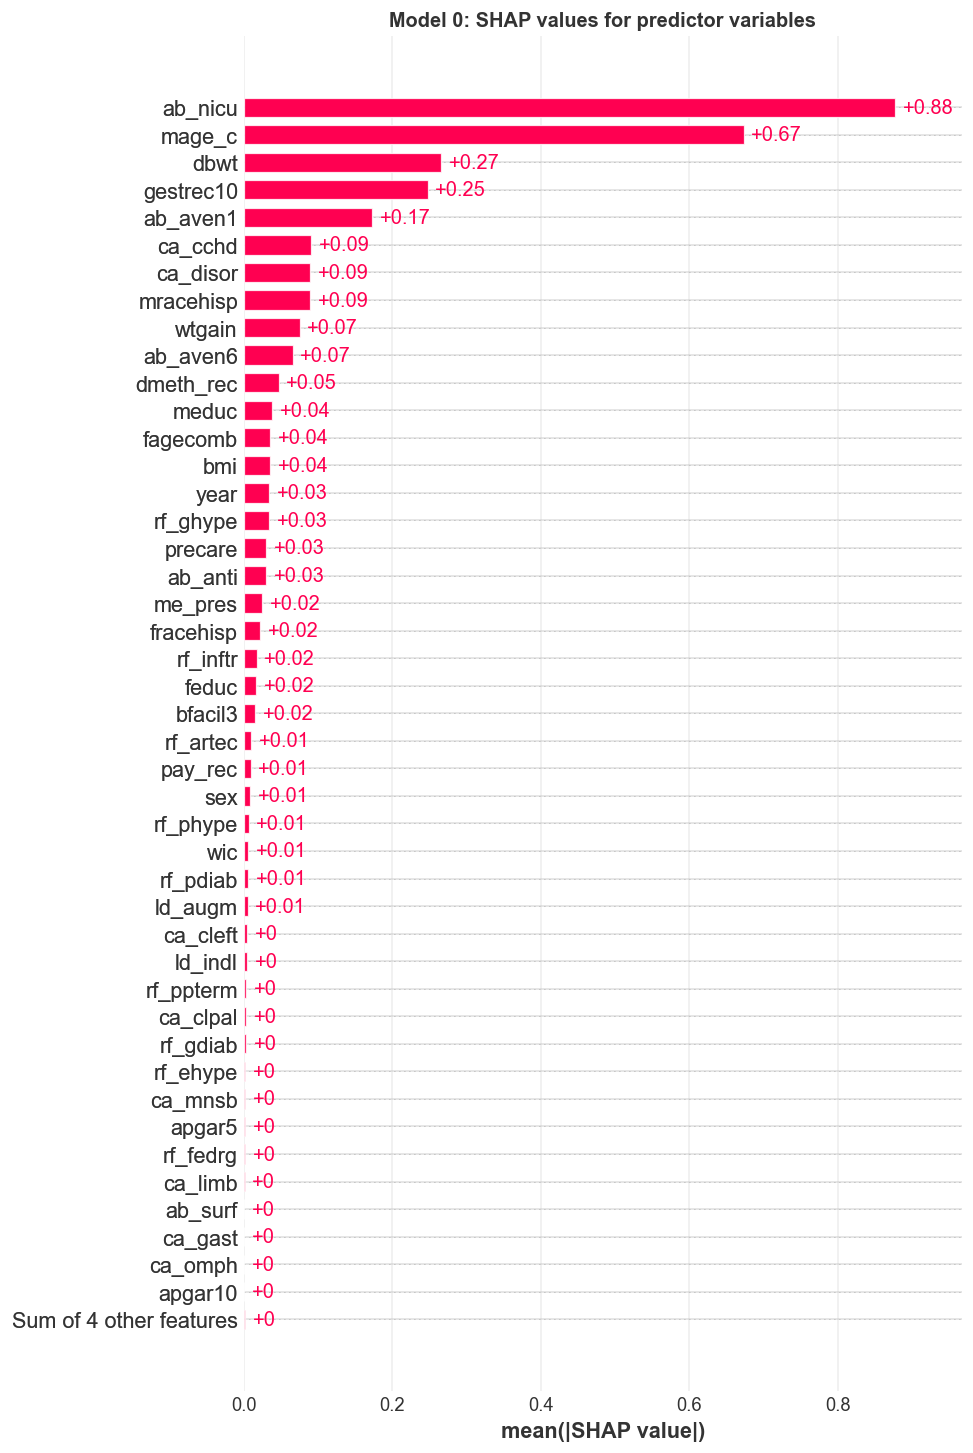

<Figure size 492x348 with 0 Axes>

In [46]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 12))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=45, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

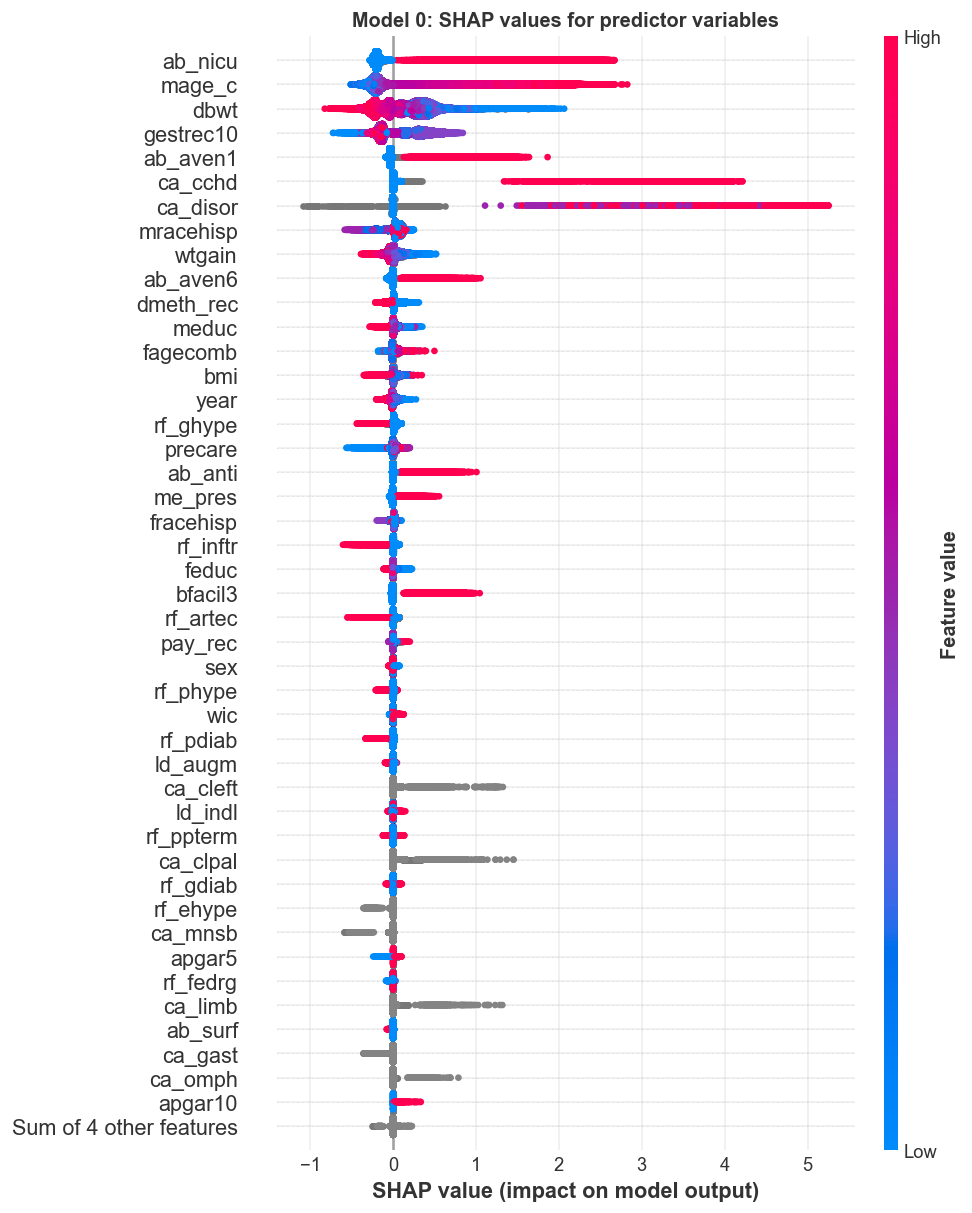

<Figure size 492x348 with 0 Axes>

In [47]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=45, plot_size=(8, 10))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

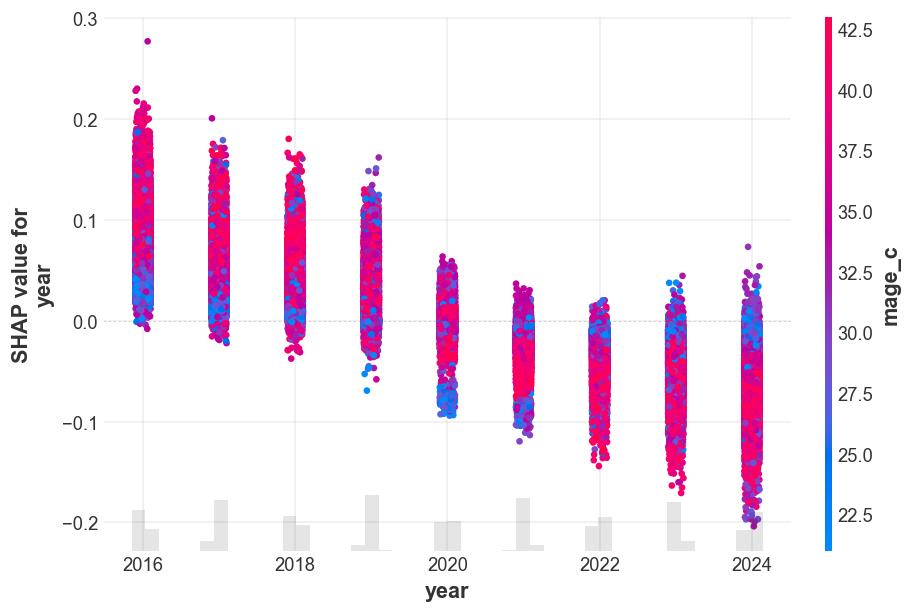

<Figure size 492x348 with 0 Axes>

In [48]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [49]:
features_to_remove_0 = [
    "ca_cdh",
    "apgar10",
    "ca_cleft",
    "rf_artec",
    "ca_omph",
    "ca_clpal",
    "wic",
    "ca_limb"
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ca_cdh', 'apgar10', 'ca_cleft', 'rf_artec', 'ca_omph', 'ca_clpal', 'wic', 'ca_limb']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_gast', 'ca_hypo', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 8 predictors): 40


In [50]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.032436	train's binary_logloss: 0.00421468	valid's average_precision: 0.0262292	valid's binary_logloss: 0.00424388
[20]	train's average_precision: 0.035668	train's binary_logloss: 0.0040824	valid's average_precision: 0.0272151	valid's binary_logloss: 0.00412895
[30]	train's average_precision: 0.0376455	train's binary_logloss: 0.00399188	valid's average_precision: 0.0273993	valid's binary_logloss: 0.00405072
[40]	train's average_precision: 0.0396116	train's binary_logloss: 0.00392425	valid's average_precision: 0.027839	valid's binary_logloss: 0.00399322
[50]	train

: 

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
#plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [ ]:
features_to_remove_1 = [
    "rf_artec",
    "rf_phype",
    "ca_cleft",
    "ca_clpal"
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Prediction


In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid))

In [ ]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [ ]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table = tail_calibration_table(y_valid, p_valid, fracs=fracs)

calibration_table["model"] = "raw"

calibration_table.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table

In [ ]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
X_full = df[features]

categorical = [col for col in categorical if col in X_full.columns]

X_full[categorical] = X_full[categorical].astype("category")

In [ ]:
p_full = gbm.predict(X_full, num_iteration=gbm.best_iteration)  # P(S=1|X)

In [ ]:
df["p_ds_lb_pred_01"] = p_full

In [ ]:
df[["year", "p_ds_lb_pred_01", "ca_down_c_p_n"]].groupby(
    "year"
).sum().reset_index()

In [ ]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [ ]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [ ]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [ ]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con.close()